In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai_audio import *

In [3]:
DATA = Path('/home/zach/Data/FS2019')
clean_folder = DATA/"train_curated"
noisy_folder = DATA/"train_noisy"

In [4]:
clean_labels = pd.read_csv(DATA/'train_curated.csv')
noisy_labels = pd.read_csv(DATA/'train_noisy.csv')

## Get number of classes

In [ ]:
clean_list = clean_labels['labels'].tolist()
split = [x.split(',') for x in clean_list]
flatten = lambda l: [ item for sublist in l for item in sublist]
len(set(flatten(split)))

# Visualize some Mel Spectrograms

In [5]:
import librosa
import librosa.display
from IPython import display as ipd
from random import randint

In [6]:
def spec(fn):
    y, sr = librosa.load(fn)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                            y_axis='mel', fmax=20000,
                            x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram of '+str(fn))
    plt.tight_layout()
    display(ipd.Audio(str(fn)))

['Race_car_and_auto_racing']

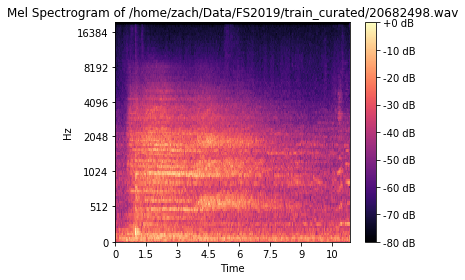

In [11]:
fn = clean_folder/clean_labels["fname"][randint(1, 1000)]
spec(fn)
getCleanLabel(fn)

# Train Resnet18 on Clean Data

In [56]:
# Calculate the overall lwlrap using sklearn.metrics function.
import sklearn.metrics
def lwrap(pred, targ):
  t = targ.cpu().numpy()
  p = pred.cpu().numpy()
  """Calculate the overall lwlrap using sklearn.metrics.lrap."""
  # sklearn doesn't correctly apply weighting to samples with no labels, so just skip them.
  sample_weight = np.sum(t > 0, axis=1)
  nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
  overall_lwlrap = sklearn.metrics.label_ranking_average_precision_score(
      t[nonzero_weight_sample_indices, :] > 0, 
      p[nonzero_weight_sample_indices, :], 
      sample_weight=sample_weight[nonzero_weight_sample_indices])
  torch_ver = torch.from_numpy(np.asarray(overall_lwlrap.astype(np.float32))).cuda()
  return torch_ver

In [57]:
lwlrap = AverageMetric(lwrap)

In [58]:
n_fft = 1024 # output of fft will have shape [513 x n_frames]
n_hop = 256  # 75% overlap between frames
n_mels = 40 # compress 513 dimensions to 40 via mel frequency scale
sample_rate = 44100
bs=24

tfms = get_frequency_batch_transforms(n_fft=n_fft, n_hop=n_hop,
                                      n_mels=n_mels, sample_rate=sample_rate)

In [8]:
def getCleanLabel(fn):
    idx = clean_labels.index[clean_labels['fname'] == fn.name].tolist()
    labs =  clean_labels["labels"][idx[0]].split(',')
    return labs

In [9]:
%%time
data = (AudioItemList
       .from_folder(clean_folder, recurse=False, extensions='.wav')
       .split_by_rand_pct()
       .label_from_func(getCleanLabel)
       .databunch(bs=bs, tfms=tfms, equal_lengths=False, num_workers=8))

Beginning calculations?
Train lengths calculated
Valid lengths calculated
Fix Lengths calculated
CPU times: user 7.86 s, sys: 1.01 s, total: 8.87 s
Wall time: 9.05 s


In [11]:
data.save("clean_data_bs24")

In [13]:
learn = create_cnn(data, models.resnet18, metrics=lwlrap)

In [14]:
learn.unfreeze()

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


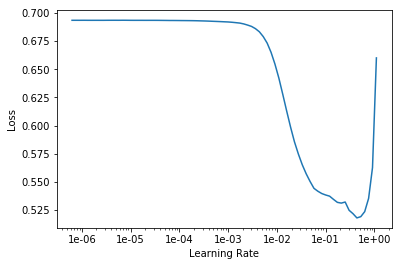

In [16]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(3, max_lr=(1e-5, 1e-3, 1e-2))

epoch,train_loss,valid_loss,lwrap,time
0,0.113153,11145.345703,0.066440,03:26
1,0.079526,6409.320312,0.062424,02:28
2,0.077541,13016.875977,0.059357,02:22


# Train Resnet18 on Noisy Data to Learn Representations

In [147]:
def getNoisyLabel(fn):
    idx = noisy_labels.index[noisy_labels['fname'] == fn.name].tolist()
    labs =  noisy_labels["labels"][idx[0]].split(',')
    return labs

Next cell takes awhile. Clips are not the same length, so `fastai_audio` makes use of `fastai`'s sortish sampler to put similar length clips in the same batch and minimize padding side effects. Downside of this is that sorting by length is considerably slower than $O(n)$ it seems...

In [149]:
%%time
noisy_data = (AudioItemList
       .from_folder(noisy_folder, recurse=False, extensions='.wav')
       .split_by_rand_pct()
       .label_from_func(getNoisyLabel)
       .databunch(bs=bs, tfms=tfms, equal_lengths=False, num_workers=12))

Beginning calculations?
Train lengths calculated
Valid lengths calculated
Fix Lengths calculated
CPU times: user 3min 8s, sys: 39.2 s, total: 3min 47s
Wall time: 22min 14s


In [21]:
noisy_data = load_data("noisy_data")

FileNotFoundError: [Errno 2] No such file or directory: 'noisy_data/data_save.pkl'

Save this so we never have to calculate it again...

In [23]:
noisy_data.save('/home/zach/Data/FS2019/train_noisy/noisy_data')

NameError: name 'noisy_data' is not defined

In [152]:
learn = create_cnn(noisy_data, models.resnet18, metrics=lwrap)

In [153]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,lwrap,time
0,0.081402,114550.804688,0.067377,14:16


KeyboardInterrupt: 